In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

This study focuses on scalable deep learning model training by leveraging the power of distributed computing to enable distributed processing of memory-intensive datasets to reduce model training time. Pytorch's Distributed Data Parallel (DDP) is used to fully utilize the computing power of multiple devices. The other distributed training for deep learning models are Model Parallelism and Pipeline Parallelism. Model Parallelism utilize hardware and memory efficiently, but it only works on certain models and is very complicated. Pipeline Parallelism distribute data across devices and works well with sequential models, but it does not use devices efficiently.

## Data Visualization

In [2]:
data_dir = '/kaggle/input/healthcare-mri-for-brain-tumor/Healthcare AI Datasets/Brain_MRI/'

In [3]:
df = pd.read_csv(data_dir + 'data_mask.csv')
df.head()

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


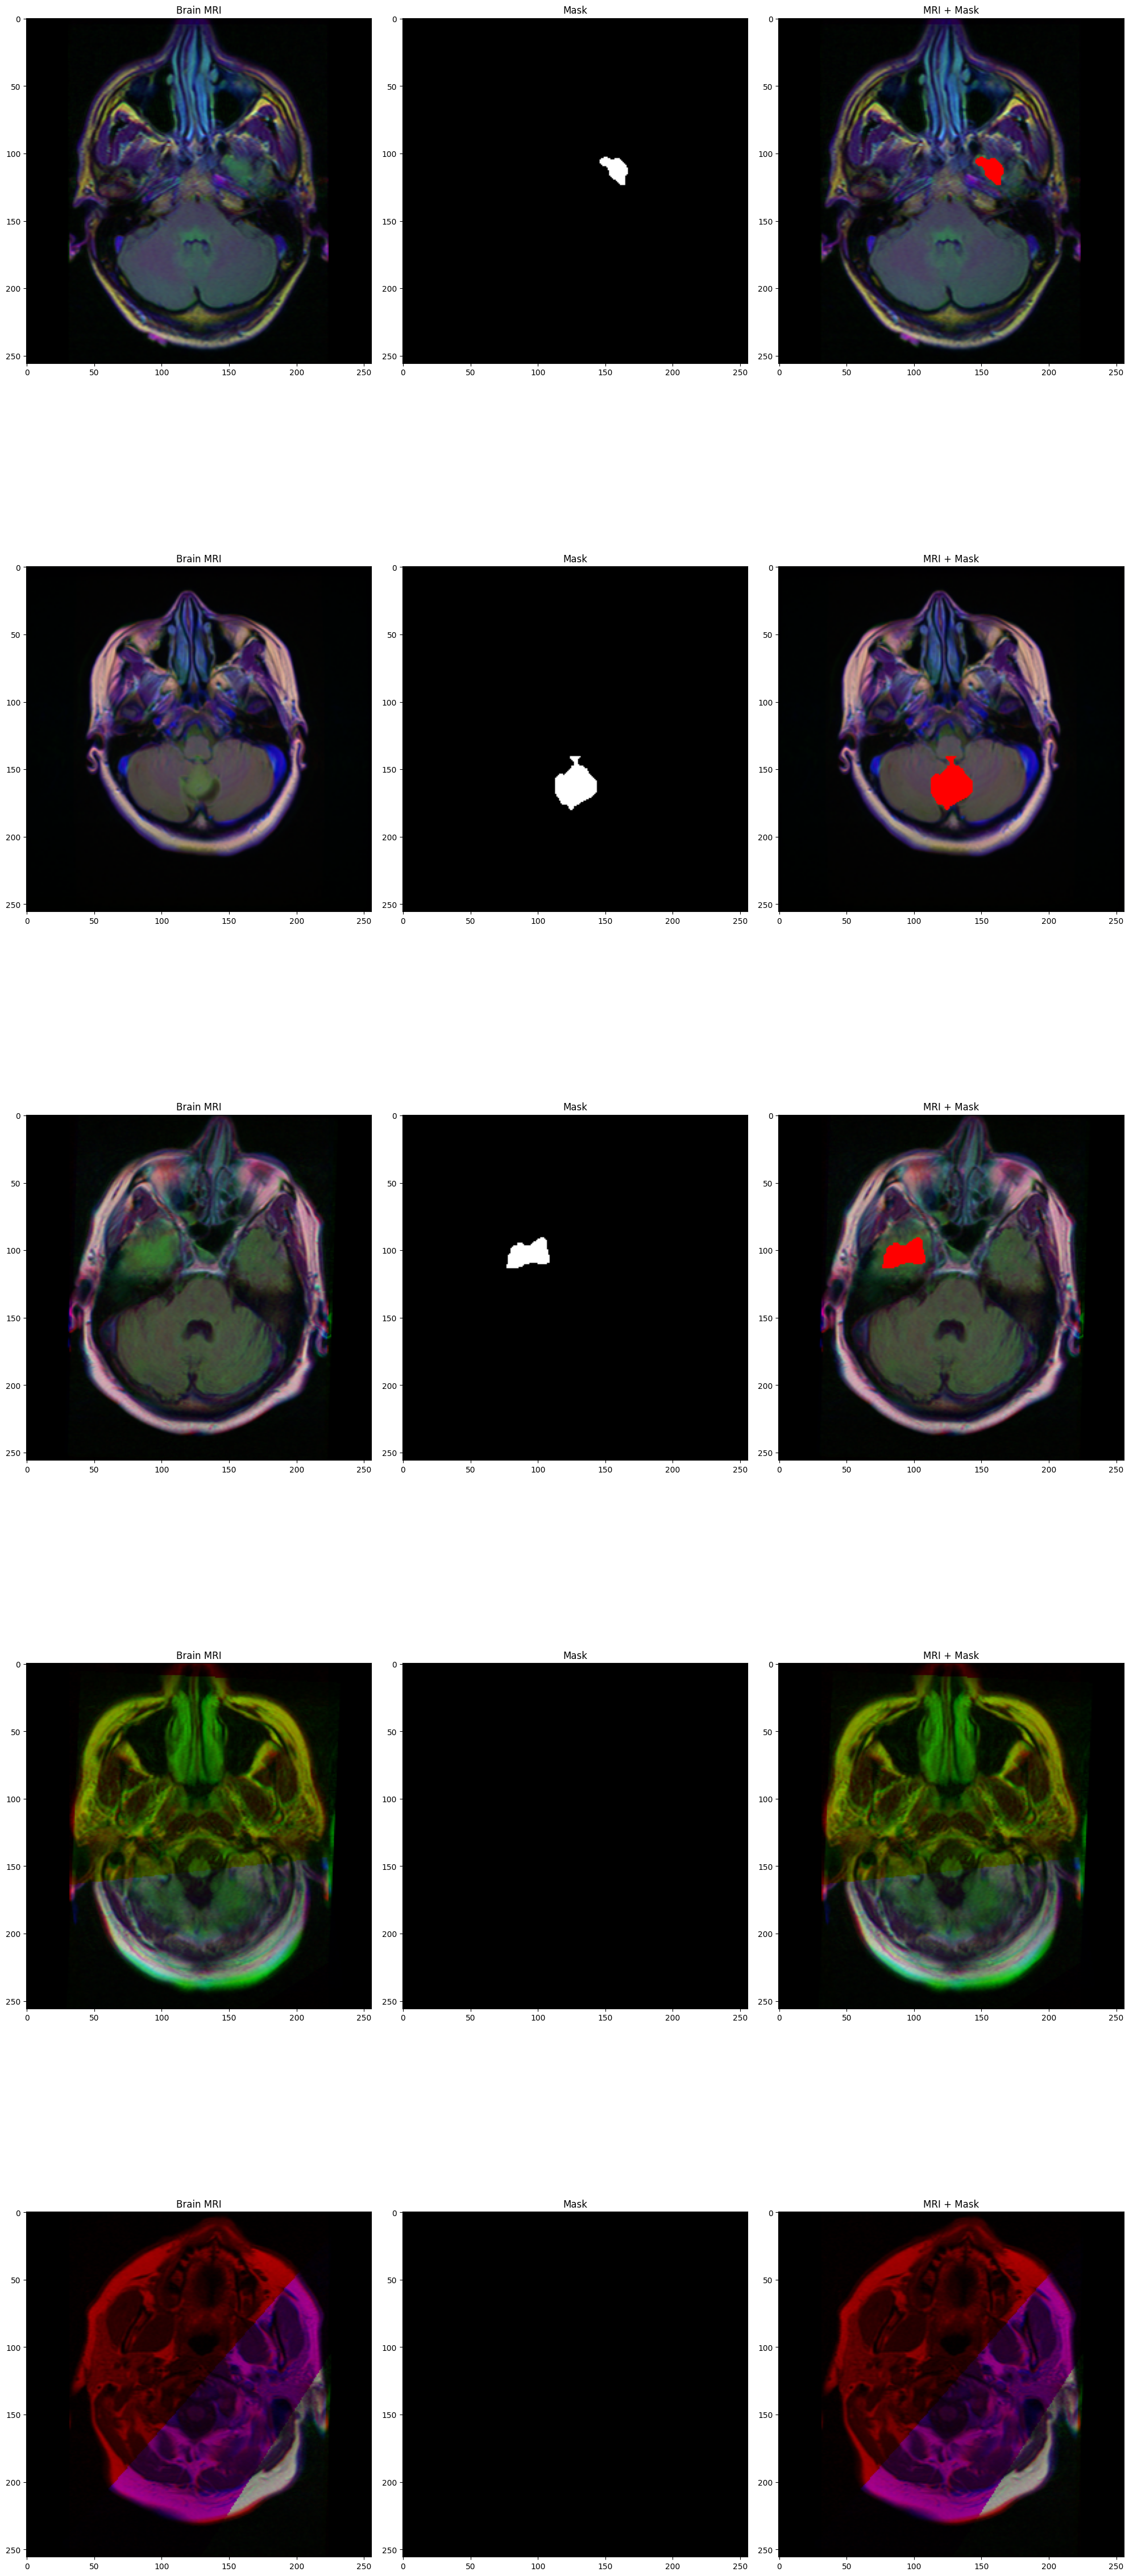

In [4]:
subset = df[df['mask'] == 1].head(3)
subset = pd.concat([subset, df.head(2)])

fig, axs = plt.subplots(5,3, figsize=(20,50))
for i in range(len(subset)):
    img = Image.open(data_dir + subset.iloc[i].image_path)
    img_array = np.array(img)
    axs[i][0].title.set_text('Brain MRI')
    axs[i][0].imshow(img)

    mask = Image.open(data_dir + subset.iloc[i].mask_path)
    mask_array = np.array(mask)
    axs[i][1].title.set_text('Mask')
    axs[i][1].imshow(mask, cmap="gray")

    img_array[mask_array == 255] = (255,0,0)
    axs[i][2].title.set_text('MRI + Mask')
    axs[i][2].imshow(img_array)
        
fig.tight_layout()

## Prepare Data for Model

The code below writes the cell block as a python file to be executed because Python's multiprocess does not work well with JupyterNotebooks.

In [5]:
%%writefile ddp.py
import os
import time
import argparse
import pandas as pd
from brainmridata import BrainMRIDataset

import torch
import torch.distributed as dist
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from PIL import Image

import pytorch_lightning as pl
import torchvision.transforms as transforms
from brainmriclassificationmodel import BrainMRIClassificationModel
from customprogressbar import CustomProgressBar

class Config:
    img_size = 224
    batch_size = 16
    num_workers = 4
    pin_memory = True
    prefetch_factor = 2 # num of batches to load in advance

def setup(rank, world_size):
    """
    Initialize the distributive process group for PyTorch training if GPUs
    are available.

    Args:
        rank (int): unique identifier for processes (0 <= rank <= world_size)
        world_size (int): total number of processes
    """
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'
    # Use gloo if no gpu available
    backend = 'nccl' if torch.cuda.is_available() else 'gloo'
    dist.init_process_group(backend, rank=rank, world_size=world_size)

def cleanup():
    """
    Clean up and destroy distributed process grouop.
    """
    dist.destroy_process_group()

def get_transforms():
    """
    Create training and validation/testing transforms for image data

    Returns:
        - Tuple(train_img_transform, train_mask_transform): tuple containing training transform for
        image data and mask data
        - Tuple(val_img_transform, val_mask_transform): tuple containing validation/testing transform
        for image data and mask data
    """
    train_img_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.Resize((Config.img_size, Config.img_size)),
        transforms.ToTensor(),
        # Use mean and std normalization from imagenet (common practice for images)
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    train_mask_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.Resize((Config.img_size, Config.img_size)),
        transforms.ToTensor()
    ])
    
    val_img_transform = transforms.Compose([
        transforms.Resize((Config.img_size, Config.img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    val_mask_transform = transforms.Compose([
        transforms.Resize((Config.img_size, Config.img_size)),
        transforms.ToTensor()
    ])
    
    return (train_img_transform, train_mask_transform), (val_img_transform, val_mask_transform)

def prepare_data(data_dir):
    """
    Prepare the dataset for model training by splitting the data and create data loaders

    Args:
        data_dir (str): the directory containing the dataset

    Returns:
        - train_loader (DataLoader): data loader that provides the train data batch
        - val_loader (DataLoader): data loader that provides the validation data batch
        - test_loader (DataLoader): data loader that provides the test data batch
    """
    df = pd.read_csv(data_dir + 'data_mask.csv')
    train_df, test_df = train_test_split(df, stratify=df['mask'], test_size=0.3, random_state=42)
    val_df, test_df = train_test_split(test_df, stratify=test_df['mask'], test_size=0.3, random_state=42)

    train_transforms, val_transforms = get_transforms()
    # Initialize datasets
    train_dataset = BrainMRIDataset(train_df, base_path=data_dir, transforms=train_transforms)
    val_dataset = BrainMRIDataset(val_df, base_path=data_dir, transforms=val_transforms)
    test_dataset = BrainMRIDataset(test_df, base_path=data_dir, transforms=val_transforms)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.batch_size,
        num_workers=Config.num_workers,
        pin_memory=Config.pin_memory,
        shuffle=True,
        drop_last=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.batch_size,
        num_workers=Config.num_workers,
        pin_memory=Config.pin_memory
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=Config.batch_size,
        num_workers=Config.num_workers,
        pin_memory=Config.pin_memory
    )

    return train_loader, val_loader, test_loader

def train(model, device, criterion, optimizer):
    """
    Perform one training epoch for given model

    Args:
        model (nn.Module): neural network module to train
        device (torch.device): target device for training ('cuda' or 'cpu')
        train_loader (DataLoader): data loader that provides the training batch
        criterion (nn.Module): loss function to optimize
        optimizer (Optimizer): optimization algorithm for training
    """
    for images, labels in train_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def evaluate(model, device, loader, rank):
    """
    Evaluate the model performance on dataset

    Args:
        model (nn.Module): neural network module to evaluate
        device (torch.device): target device for training ('cuda' or 'cpu')
        loader (DataLoader): data loader that provides the data batch
        rank (int): unique identifier for processes (0 <= rank <= world_size)

    Returns:
        - total: total number of samples
        - correct: number of correctly classified samples
    """
    total = correct = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
    
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == labels).sum().item()
    return total, correct

def main_worker(rank, world_size, epochs):
    """
    Training loop for distributed neural network model training

    Args:
        rank (int): unique identifier for processes (0 <= rank <= world_size)
        world_size (int): total number of processes
        epoch (int): number of complete training passes through the dataset
    """
    setup(rank, world_size)
    device = torch.device(f'cuda:{rank}' if torch.cuda.is_available() else 'cpu')
    (train_loader, val_loader, _), train_sampler = prepare_data(df, rank, world_size)

    criterion = torch.nn.CrossEntropyLoss()
    model = BrainMRIClassificationModel(criterion)

    if world_size > 1:
        model = DDP(model, device_ids=[rank])

    # Training setup
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    print('Begin model training.')
    for epoch in range(epochs):
        train_loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', unit='batch')

        train_sampler.set_epoch(epoch)
        model.train()

        train(model, device, criterion, optimizer)
        scheduler.step()
    
        if rank == 0:
            model.eval()
            total, correct = evaluate(model, device, val_loader, rank)
            total_time = time.time() - start_time
            accuracy = round(100 * correct / total, 2)
            print(f'Time: {total_time:.2f}s | Val Acc: {accuracy}%')
    cleanup()

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--epoch', type=int, default=3)
    parser.add_argument('--ddp', type=bool, default=False)
    parser.add_argument('--model', type=str, default='resnet50')

    args = parser.parse_args()
    epochs = args.epoch
    distributed = args.ddp
    data_dir = '/kaggle/input/healthcare-mri-for-brain-tumor/Healthcare AI Datasets/Brain_MRI/'
    print('Preparing data for model training.')
    train_loader, val_loader, test_loader = prepare_data(data_dir)
    print(f'Training model using {"ddp" if distributed else "single gpu"}')

    
    trainer = pl.Trainer(
        max_epochs=epochs,
        accelerator="auto", # Detect hardware type e.g. GPU/TPU
        devices=("auto" if distributed else 1), # Count number of devices, will use all available GPUs
        strategy="auto", # Distributed strategy, use DDP if multi-GPU
        enable_progress_bar=True,
        callbacks=[CustomProgressBar()]
    )
    model = BrainMRIClassificationModel(model=args.model)

    start_time = time.time()
    # Training model
    trainer.fit(model, train_loader, val_loader)
    print(f'Total model training time: {time.time() - start_time} seconds')

    # Destroy process group (if using DDP) to let only rank 0 perform testing, else program will freeze and timeout
    if distributed:
        torch.distributed.destroy_process_group()

    if trainer.is_global_zero:
        # Force single GPU for testing
        test_trainer = pl.Trainer(
            accelerator="auto",
            devices=1,
            enable_progress_bar=True
        )
        test_trainer.test(model, test_loader)

Writing ddp.py


## Resnet50 Model

### Train Model Using Single GPU

In [6]:
!python ddp.py --epoch 3

Preparing data for model training.
Training model using single gpu
2025-04-27 04:58:33.122212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745729913.357226      80 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745729913.425560      80 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Epoch 3: 100%|████| 171/171 [00:33<00:00,  5.11it/s, loss=0.421, val_loss=0.421]
Total model training time: 114.74494743347168 seconds
Testing DataLoader 0: 100%|█████████████████████| 23/23 [00:01<00:00, 16.92it/s]
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━

### Train Model Using Two GPU via DDP

In [7]:
!python ddp.py --epoch 3 --ddp True

Preparing data for model training.
Training model using ddp
Preparing data for model training.
Training model using ddp
2025-04-27 05:00:44.837715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745730044.859914     258 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745730044.866841     258 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/usr/local/lib/python3.11/dist-packages/pytorch

## Resnet101 Model

### Train Model Using Single GPU

In [8]:
!python ddp.py --epoch 3 --model resnet101

Preparing data for model training.
Training model using single gpu
2025-04-27 05:02:06.916627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745730126.939958     593 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745730126.946744     593 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Epoch 3: 100%|████| 171/171 [01:01<00:00,  2.77it/s, loss=0.458, val_loss=0.458]
Total model training time: 197.77861428260803 seconds
Testing DataLoader 0: 100%|█████████████████████| 23/23 [00:02<00:00, 10.70it/s]
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━

### Train Model Using Two GPU via DDP

In [9]:
!python ddp.py --epoch 3 --ddp True --model resnet101

Preparing data for model training.
Training model using ddp
Preparing data for model training.
Training model using ddp
2025-04-27 05:05:43.111428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745730343.133970     771 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745730343.140830     771 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/usr/local/lib/python3.11/dist-packages/pytorch

The training time appears to be reduced by around half when using DDP with 2 GPUs. For ResNet50, the test accuracy, precision, and recall appears to be slightly lowered, but for ResNet101, the difference is significant. In theory, the results should not vary much if at all. Several runs were performed, and the results using DDP were always slightly lower.